Citations & Resources
Used most of the idea from this kernal 
https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter
Data used: converted 224x224 sized image from the kernal 

https://www.kaggle.com/xhlulu/recursion-2019-load-resize-and-save-images

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['recursion-cellular-image-classification', 'recursion-complete', 'densenet-keras']


In [2]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.densenet import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 224
NUM_CLASSES = 1108

Using TensorFlow backend.


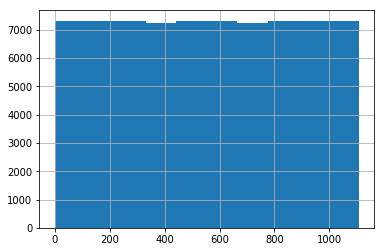

In [3]:
df_train = pd.read_csv('../input/recursion-complete/new_train.csv')
df_test = pd.read_csv('../input/recursion-complete/new_test.csv')

x = df_train['filename']
y = df_train['sirna']

x, y = shuffle(x, y, random_state=10)
y.hist()


In [4]:
y = to_categorical(y, num_classes=NUM_CLASSES)

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=10)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(62075,)
(62075, 1108)
(10955,)
(10955, 1108)


In [6]:
# https://github.com/aleju/imgaug
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(
        iaa.OneOf([
            iaa.Add((-10, 10), per_channel=0.5),
            iaa.Multiply((0.9, 1.1), per_channel=0.5),
            iaa.ContrastNormalization((0.9, 1.1), per_channel=0.5)
        ])
    ),
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    # iaa.Flipud(0.5)
],random_order=True)

In [7]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):

            img = cv2.imread('../input/recursion-complete/train/train/'+sample)
#             try:
#                 img.shape
#                 print("checked for shape".format(img.shape))
#             except AttributeError:
#                 print("shape not found")
#             img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32)/255
#         print(batch_images.shape)
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/recursion-complete/train/train/'+sample)
#             img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32)/255
        
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.densenet import DenseNet121
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras.optimizers import Nadam
from keras import backend as K
import keras
from keras.models import Model

In [9]:
def create_model(input_shape,n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')
    x = GlobalAveragePooling2D()(base_model.output)
#     x = Dropout(0.1)(x)
    x = Dense(1024, activation='relu')(x)
 
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [10]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 8
checkpoint = ModelCheckpoint('../working/Densenet121.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(input_shape=(SIZE,SIZE,3),n_out=NUM_CLASSES)


In [11]:
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=1108, bsize=8, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [12]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Nadam(1e-3))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=30,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1)

Epoch 1/30
485/485 [==============================] - 225s 463ms/step - loss: 6.7310
Epoch 2/30
485/485 [==============================] - 192s 395ms/step - loss: 6.0755
Epoch 3/30
485/485 [==============================] - 196s 405ms/step - loss: 5.6511
Epoch 4/30
485/485 [==============================] - 194s 400ms/step - loss: 5.3228
Epoch 5/30
485/485 [==============================] - 193s 398ms/step - loss: 5.0437
Epoch 6/30
485/485 [==============================] - 194s 400ms/step - loss: 4.8032
Epoch 7/30
485/485 [==============================] - 191s 394ms/step - loss: 4.6010
Epoch 8/30
485/485 [==============================] - 193s 397ms/step - loss: 4.4244
Epoch 9/30
485/485 [==============================] - 191s 395ms/step - loss: 4.2595
Epoch 10/30
485/485 [==============================] - 190s 391ms/step - loss: 4.1006
Epoch 11/30
485/485 [==============================] - 192s 396ms/step - loss: 3.9547
Epoch 12/30
485/485 [==============================] - 193s 399

In [13]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [csv_logger, reduceLROnPlat]
model.compile(optimizer=Nadam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=2, use_multiprocessing=True,
    callbacks=callbacks_list)

Epoch 1/10
7760/7760 [==============================] - 1410s 182ms/step - loss: 5.3574 - acc: 0.0778 - val_loss: 5.6786 - val_acc: 0.0869
Epoch 2/10
4736/7760 [=================>............] - ETA: 8:34 - loss: 4.6768 - acc: 0.1360

In [14]:
model.save_weights("../working/Densenet121.h5")

In [15]:
submit = pd.read_csv('../input/recursion-cellular-image-classification/sample_submission.csv')
model.load_weights('../working/Densenet121.h5')
predicted = []

In [16]:
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/recursion-complete/test/test/', name+'_s1.jpeg')
    image = cv2.imread(path)
#     image = cv2.resize(image, (SIZE, SIZE))
    score_predict = model.predict((image[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))


19897it [07:13, 45.86it/s]


In [17]:
submit['sirna'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()
# submission['sirna'] = preds.astype(int)
# submission.to_csv('submission.csv', index=False, columns=['id_code','sirna'])


,id_code,sirna
0,HEPG2-08_1_B03,1042
1,HEPG2-08_1_B04,1006
2,HEPG2-08_1_B05,57
3,HEPG2-08_1_B06,94
4,HEPG2-08_1_B07,254
